## BERT Classifier using ktrain package

In [37]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

#### Check for GPU presence

In [38]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
!nvidia-smi

Mon May 22 21:02:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    29W /  70W |   4663MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
tf.__version__

'2.12.0'

In [41]:
!pip install ktrain --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
COLAB = True
if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/MyDrive/capp30255/"
else:
    # Change path to appropriate location
    PATH = '/Users/victor/Desktop/capp30255_project/ml_adv_proj/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [43]:
import ktrain
from ktrain import text

#### Check available text classifiers in ktrain

In [44]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


### Load Data

In [45]:
import os
df = pd.read_pickle(os.path.join(PATH, 'data_final.pkl'))

In [46]:
# filter only to house bills and senate bills
df = df[(df['BillType'] == 'hr') | (df['BillType'] == 's')]
assert df.shape == (18907, 94), 'df shape is not correct'

### Prepare source data

In [47]:
#creating the target variable
df['target_class'] = (df['PassH'] == 1) | (df['PassS'] == 1)

## STEP 1:  Load and Preprocess the Dataset


In [48]:
x_train, x_test, y_train, y_test = train_test_split(df['summary'].values.tolist(),
                                                    df['target_class'].values.tolist(),
                                                    test_size=0.30,
                                                    shuffle=True,
                                                    random_state=22)

## STEP 2:  Load a pretrained domain specific BERT model and wrap it in a `ktrain.Learner` object

In [49]:
MODEL_NAME = 'nlpaueb/bert-base-uncased-eurlex'
max_len = 200 # each document can be of most <maxLen> words. 0 is used as padding ID.
batch_size = 16 # Check best size
t = text.Transformer(MODEL_NAME,
                     maxlen=max_len,
                     class_names = ['Negative', 'Positive'])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()



preprocessing train...
language: en
train sequence lengths:
	mean : 251
	95percentile : 563
	99percentile : 2165


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 268
	95percentile : 558
	99percentile : 2403


In [51]:
learner = ktrain.get_learner(model,
                             train_data=trn,
                             val_data=val,
                             batch_size=batch_size)

## STEP 3: Train the Model


In [52]:
learner.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
827/827 [==============================] - 574s 668ms/step - loss: 0.2708 - accuracy: 0.9251
Epoch 2/3
827/827 [==============================] - 557s 674ms/step - loss: 0.3800 - accuracy: 0.9054
Epoch 3/3
827/827 [==============================] - 10s 11ms/step - loss: 1.4932 - accuracy: 0.7268


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 4.06E-06
	Min numerical gradient (purple): 3.83E-05
	Min loss divided by 10 (omitted from plot): 1.41E-05


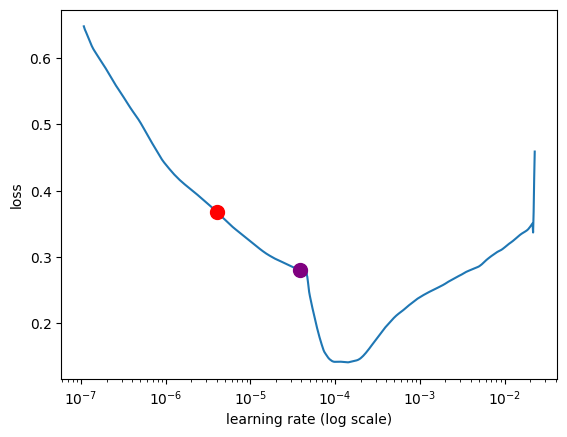

In [53]:
learner.lr_plot(suggest=True)

In [54]:
learningRate = 4.06E-06
numEpoch = 4
learner.autofit(learningRate,
                numEpoch)



begin training using triangular learning rate policy with max lr of 4.06e-06...
Epoch 1/4
828/828 [==============================] - 660s 771ms/step - loss: 0.1797 - accuracy: 0.9374 - val_loss: 0.1105 - val_accuracy: 0.9538
Epoch 2/4
828/828 [==============================] - 638s 771ms/step - loss: 0.1074 - accuracy: 0.9578 - val_loss: 0.1043 - val_accuracy: 0.9570
Epoch 3/4
828/828 [==============================] - 635s 766ms/step - loss: 0.0976 - accuracy: 0.9630 - val_loss: 0.1011 - val_accuracy: 0.9575
Epoch 4/4
828/828 [==============================] - 635s 767ms/step - loss: 0.0900 - accuracy: 0.9655 - val_loss: 0.0985 - val_accuracy: 0.9593


We can use the `learner.validate` method to test our model against the validation set.

In [55]:
learner.validate(val_data=val)

178/178 [==============================] - 81s 440ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5175
           1       0.77      0.76      0.77       498

    accuracy                           0.96      5673
   macro avg       0.87      0.87      0.87      5673
weighted avg       0.96      0.96      0.96      5673



array([[5062,  113],
       [ 118,  380]])

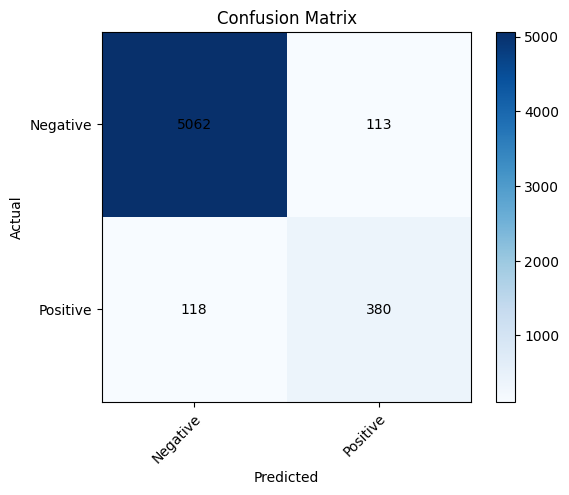

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Given confusion matrix
cm = np.array([[5062, 113],
       [118,  380]])

# Define class labels
labels = ['Negative', 'Positive']

# Create heatmap
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Set labels and title
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Show the plot
plt.show()